# Brain Stroke Dataset - Analysis, Part V

**Author:** Jakub Bednarz

**Previous parts**: [Part I](https://github.com/mim-uw/eXplainableMachineLearning-2023/blob/main/Homeworks/HW1/JakubBednarz/Analysis.ipynb), [Part II](https://htmlpreview.github.io/?https://github.com/mim-uw/eXplainableMachineLearning-2023/blob/main/Homeworks/HW2/JakubBednarz/Analysis%2C%20Part%20II.html), [Part III](https://htmlpreview.github.io/?https://github.com/mim-uw/eXplainableMachineLearning-2023/blob/main/Homeworks/HW3/JakubBednarz/Analysis%2C%20Part%20III.html), [Part IV](https://htmlpreview.github.io/?https://github.com/mim-uw/eXplainableMachineLearning-2023/blob/main/Homeworks/HW4/JakubBednarz/Analysis%2C%20Part%20IV.html)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from typing import Union
import plotly
import plotly.express as px
import plotly.offline as py
import plotly.io as pio
import plotly.graph_objects as go
from scipy.special import logit
from copy import deepcopy
import warnings

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.base import BaseEstimator, ClassifierMixin
from xgboost.sklearn import XGBClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, \
    LassoCV
from sklearn.metrics import roc_auc_score
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.svm import LinearSVC

import optuna
from optuna.trial import Trial, FrozenTrial
from optuna.integration.sklearn import OptunaSearchCV

import shap
import shap.maskers
import dalex
import lime

warnings.filterwarnings(action="ignore")
pio.renderers.default = "notebook"
plotly.offline.init_notebook_mode(connected=True)

In [2]:
df = pd.read_csv("brain_stroke.csv")
for col in ("hypertension", "heart_disease"):
    df[col] = df[col].apply(lambda idx: ["No", "Yes"][idx])

In [3]:
# for name, values in df.select_dtypes("object").iteritems():
#     print(name, values.unique())

In [4]:
class ColumnTransformerEx(ColumnTransformer):
    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            return pd.DataFrame(
                data=np.asarray(super().transform(X)),
                columns=self.get_feature_names_out(),
                index=X.index,
            )
        else:
            return super().transform(X)
    
    def fit_transform(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            return pd.DataFrame(
                data=np.asarray(super().fit_transform(X, y)),
                columns=self.get_feature_names_out(),
                index=X.index,
            )
        else:
            return super().fit_transform(X, y)

cat_features = [
    "gender",
    "ever_married",
    "work_type",
    "Residence_type",
    "smoking_status",
    "hypertension",
    "heart_disease",
]

one_tf = ColumnTransformerEx(
    transformers=[
        (col, OneHotEncoder(drop="if_binary"), [col])
        for col in cat_features],
    remainder="passthrough",
    verbose_feature_names_out=False,
)

ord_tf = ColumnTransformerEx(
    transformers=[
        (col, OrdinalEncoder(), [col])
        for col in cat_features],
    remainder="passthrough",
    verbose_feature_names_out=False,
)

one_df = one_tf.fit_transform(df)
ord_df = ord_tf.fit_transform(df)

all_features = ord_df.columns.tolist()

cat_idxes = [all_features.index(feat) for feat in cat_features]

cat_names = {
    idx: OrdinalEncoder().fit(df[[feat]]).categories_[0]
    for idx, feat in zip(cat_idxes, cat_features)
}

X_tf = ColumnTransformerEx(
    transformers=[
        (col, OneHotEncoder(drop="if_binary"), [col])
        for col in cat_features],
    remainder="passthrough",
    verbose_feature_names_out=False,
)

In [5]:
def split(df):
    X, y = df.drop(columns=["stroke"]), df["stroke"]
    train_X, test_X, train_y, test_y = \
        train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    return train_X, test_X, train_y, test_y

train_X, test_X, train_y, test_y = split(df)
X_tf = X_tf.fit(train_X)
train_X_one, test_X_one, train_y_one, test_y_one = split(one_df)
train_X_ord, test_X_ord, train_y_ord, test_y_ord = split(ord_df)

In [6]:
conv_tf = ColumnTransformer(
    transformers=[
        (col, OneHotEncoder(drop="if_binary"), [idx])
        for col, idx in zip(cat_features, cat_idxes)],
    remainder="passthrough",
    verbose_feature_names_out=False,
)

conv_tf = conv_tf.fit(ord_df.drop(columns=["stroke"]).to_numpy())

In [7]:
class XGBClassifier_Optuna:
    def fit(self, X, y):
        def model_fn(trial: Union[Trial, FrozenTrial]):
            return XGBClassifier(
                max_depth=int(trial.suggest_float("max_depth", 3, 18, step=1)),
                gamma=trial.suggest_float("gamma", 1, 9),
                reg_alpha=int(trial.suggest_float("reg_alpha", 40, 180, step=1)),
                reg_lambda=trial.suggest_float("reg_lambda", 0, 1),
                colsample_bytree=trial.suggest_float("colsample_bytree", 0.5, 1),
                min_child_weight=int(trial.suggest_float("min_child_weight", 0, 10, step=1)),
                n_estimators=180,
                seed=42,
            )

        sample_wt = compute_sample_weight(
            class_weight="balanced",
            y=y,
        )
        
        fit_params = dict(
            sample_weight=sample_wt,
        )

        def objective(trial: optuna.Trial):
            model = model_fn(trial)
            return np.min(cross_val_score(model, X, y, scoring="roc_auc", fit_params=fit_params))
        
        optuna.logging.set_verbosity(optuna.logging.WARN)
        sampler = optuna.samplers.TPESampler(seed=99)
        study = optuna.create_study(direction="maximize", sampler=sampler)
        study.optimize(objective, n_trials=16)

        model = model_fn(study.best_trial)
        model.fit(X, y, **fit_params)
        return model

xgb_model = XGBClassifier_Optuna().fit(train_X_one, train_y_one)

In [8]:
# roc_auc_score(test_y_one, xgb_model.predict(test_X_one))

In [9]:
lr_model_cv = LogisticRegressionCV(
    solver="liblinear",
    scoring="roc_auc",
    class_weight="balanced",
)

lr_model_cv = lr_model_cv.fit(train_X_one, train_y_one)

lr_model = LogisticRegression(
    solver="liblinear",
    class_weight="balanced",
    C=lr_model_cv.C_[0],
)

lr_model = lr_model.fit(train_X_one, train_y_one)

In [10]:
# roc_auc_score(test_y_one, lr_model.predict(test_X_one))

In [11]:
class SVC_Optuna:
    def fit(self, X, y):
        def model_fn(trial: Union[Trial, FrozenTrial]):
            return LinearSVC(
                penalty=trial.suggest_categorical("penalty", ["l1", "l2"]),
                dual=False,
                C=trial.suggest_loguniform("C", 1e-4, 1e4),
                random_state=42,
            )

        sample_wt = compute_sample_weight(
            class_weight="balanced",
            y=y,
        )
        
        fit_params = dict(
            sample_weight=sample_wt,
        )

        def objective(trial: optuna.Trial):
            model = model_fn(trial)
            return np.min(cross_val_score(model, X, y, scoring="roc_auc", fit_params=fit_params))
        
        optuna.logging.set_verbosity(optuna.logging.WARN)
        sampler = optuna.samplers.TPESampler(seed=99)
        study = optuna.create_study(direction="maximize", sampler=sampler)
        study.optimize(objective, n_trials=16)

        model = model_fn(study.best_trial)
        model.fit(X, y, **fit_params)
        return model

svc_model = SVC_Optuna().fit(train_X_one, train_y_one)

In [12]:
# roc_auc_score(test_y_one, svc_model.predict(test_X_one))

In [13]:
lr_model_cv = LogisticRegressionCV(
    solver="liblinear",
    scoring="roc_auc",
    class_weight="balanced",
)

lr_model_cv = lr_model_cv.fit(train_X_one, train_y_one)

lr_model = LogisticRegression(
    solver="liblinear",
    class_weight="balanced",
    C=lr_model_cv.C_[0],
)

lr_model = lr_model.fit(train_X_one, train_y_one)

In [14]:
lasso_model = LassoCV().fit(train_X_one, train_y_one)

In [15]:
# roc_auc_score(test_y_one, lasso_model.predict(test_X_one))

## Introduction

The goal for today is to become familiar with *Permutation-based Variable Importance* (PVI). In particular, we will investigate how much our models depend on the features in the data set by randomly *permuting* their values, thereby breaking the relationship between the feature and the target - in our case, brain stroke prediction.

First, let's take the familiar XGBoost model from previous parts of this analysis and apply PVI technique to it.

In [16]:
from sklearn.inspection import permutation_importance

def pvi_for(model, all=False, sort=True):
    imp = permutation_importance(
        model,
        test_X_one, test_y_one,
        n_repeats=10,
        scoring="roc_auc",
    )
    
    imp_df = pd.DataFrame(
        data=imp["importances"].T,
        columns=test_X_one.columns,
    )
    
    if not all:
        mask = np.count_nonzero(imp_df, axis=0) > 0
        imp_df = imp_df.iloc[:,mask]
    
    if sort:
        mean_vi = imp_df.mean(axis=0)
        imp_df = imp_df.iloc[:,np.argsort(mean_vi)]

    fig = px.box(pd.melt(imp_df),
        y="variable",
        x="value",
    )
    return fig

In [17]:
pvi_for(xgb_model)

The way to interpret this result is as follows: the y-axis represents predictor features in the dataset, such as `age`. For each of them, we computed *baseline* value (in this cause [AUROC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic),) and performed a number of permutations of the values associated with said feature. Then, we've gathered the differences of the values of the metric with the previously computed baseline value. Thus, for example, we can see that permuting `age` reduces the area-under-ROC score by ~0.27 in the median case, which is a significant value and which indicates that the XGB model relies heavily on the value of the `age` feature. In contrast, other variables do not seem to have so great an effect - in fact, in selected cases permuting the value for the feature even **increases** the score, as is the case for the `bmi` variable in the median case.

As an aside, let's check what features there are in the dataset:

In [18]:
test_X_one.columns

Index(['gender_Male', 'ever_married_Yes', 'work_type_Govt_job',
       'work_type_Private', 'work_type_Self-employed', 'work_type_children',
       'Residence_type_Urban', 'smoking_status_Unknown',
       'smoking_status_formerly smoked', 'smoking_status_never smoked',
       'smoking_status_smokes', 'hypertension_Yes', 'heart_disease_Yes', 'age',
       'avg_glucose_level', 'bmi'],
      dtype='object')

We can also note that not all the features are represented here (such as, for example, `Residence_type_Urban`) - this indicates that the score doesn't change at all when permuting the values for this feature, which by extension means that the model doesn't seem to use said feature's values at all.

### Train three more candidate models.

As in the case of previous explainability methods, we can indirectly use them for comparing (and, presumably, ultimately selecting one of) the predictive models we've trained. Let's therefore do it for PVI as well.

- Linear regression model.

In [19]:
pvi_for(lr_model)

- Classifier based on Support Vector Machines.

In [20]:
pvi_for(svc_model)

- Lasso model.

In [21]:
pvi_for(lasso_model)

I would say that, broadly speaking, they seem to yield fairly similar results, which is to say that `age` is, essentially, the only relevant feature. One thing to note is that Lasso model depends on a smaller amount of variables in its predictions compared to the linear regression- or SVM-based models. This is by design, as the Lasso-regularized models, by including $L^1$ loss, tend to converge to solutions which minimize the number of selected variables. It is nevertheless reassuring to see this effect in practice.

### Compare PVI for a tree-based model with `feature_importances_` and SHAP

We've previously investigated a number of other techniques for evaluating variable importance. One of them was SHAP, discussed in [Part II](https://htmlpreview.github.io/?https://github.com/mim-uw/eXplainableMachineLearning-2023/blob/main/Homeworks/HW2/JakubBednarz/Analysis%2C%20Part%20II.html). Another measure of variable importance, for tree-based models, is *Gini importance* of a feature, defined as the normalized total reduction of Gini impurity (or other criterion used in training the forest) brought by that feature. It is therefore somewhat similar to how PVI works, except that we measure reductions of different things (score vs impurity). It may prove enlightening to compare these VI methods for one our models. Let's do this for the XGBoost model.

- PVI

In [22]:
pvi_for(xgb_model)

- Impurity-based importance

In [23]:
fig = go.Figure()
idxes = np.argsort(xgb_model.feature_importances_)
idxes = idxes[xgb_model.feature_importances_[idxes] > 0]

fig.add_trace(go.Scatter(
    y=test_X_one.columns[idxes],
    x=xgb_model.feature_importances_[idxes],
    mode="markers",
    marker=dict(color="red"),
))
fig

- SHAP values

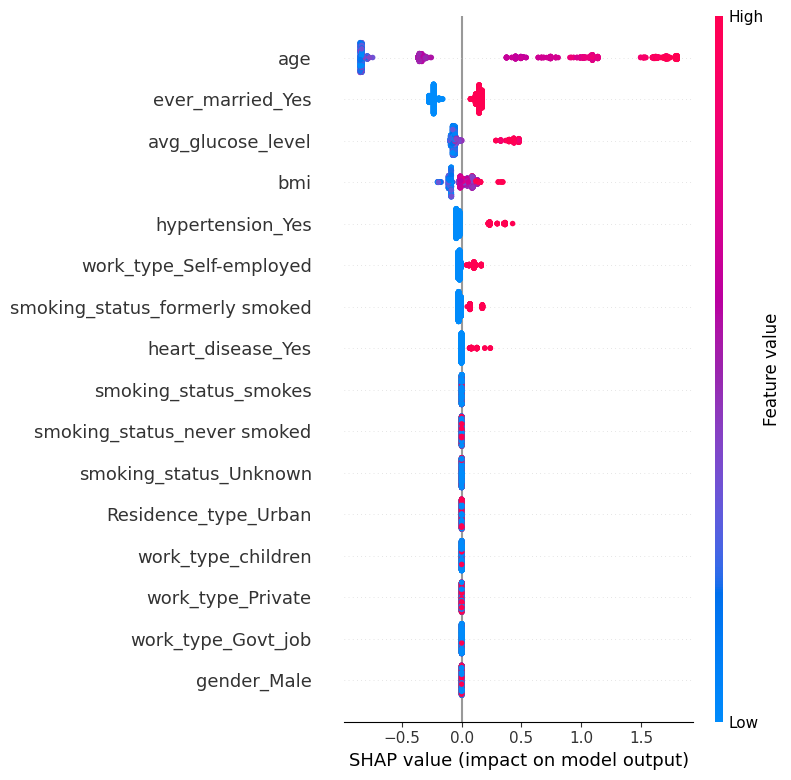

In [24]:
xgb_expl = shap.TreeExplainer(xgb_model, train_X_one)
shap.summary_plot(xgb_expl(test_X_one))

What conclusions can we draw from these plots? In general, the features which are indicated to be of import in the process of model's predictions are the same, however the *order* may be switched up. Another thing to note is that these metrics are not exactly directly comparable, in that mean decrease in score and mean decrease in impurity are two distinct quantities (as for the relationship between the two, I cannot be said to have deep enough knowledge about impurity functions in decision tree learning to say anything meaningful.) In fact, in my estimation, from the stakeholder's PoV the impurity-based importance is probably not very useful since it's not directly convertible to any real-world indicators of performance, whereas in the case of PVI mean decrease in score (choice of which is up to us) does certainly seem to be potentially useful. I would nevertheless state that the VIs seem too "coarse-grained" a measure from which to draw definite conclusions - for example, *I* certainly prefer the SHAP values, and especially the fact that we can measure impact on model output for each observation.